In [1]:
# Microsoft Malware Classification – Random Forest + GridSearchCV
# importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler

# For managing large datasets
import gc


In [5]:
import kagglehub

# Download the data set
path = kagglehub.dataset_download("muhammad4hmed/malwaremicrosoftbig")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/malwaremicrosoftbig


In [7]:
# loading the dataset and viewing it
data_path = path + '/data.csv'
df = pd.read_csv(data_path)

print("Shape:", df.shape)
df.head()


Shape: (10868, 69)


,asm_commands_add,asm_commands_call,asm_commands_cdq,asm_commands_cld,asm_commands_cli,asm_commands_cmc,asm_commands_cmp,asm_commands_cwd,asm_commands_daa,asm_commands_dd,...,asm_commands_sti,asm_commands_stos,asm_commands_sub,asm_commands_test,asm_commands_wait,asm_commands_xchg,asm_commands_xor,line_count_asm,size_asm,Class
0,436,646.0,0.0,10.0,9.0,0.0,228.0,0.0,56.0,89930,...,1.0,0.0,892.0,53.0,10.0,0.0,162.0,118529,6874624,2
1,469,262.0,0.0,4.0,1.0,4.0,185.0,4.0,20.0,3464,...,3.0,7.0,846.0,8.0,0.0,9.0,19.0,7937,460288,8
2,1587,1828.0,0.0,0.0,31.0,0.0,689.0,0.0,904.0,24833,...,1.0,0.0,4005.0,680.0,44.0,0.0,418.0,90625,5256192,9
3,213,227.0,0.0,0.0,3.0,0.0,127.0,0.0,132.0,71979,...,0.0,0.0,437.0,78.0,0.0,0.0,199.0,83201,4825600,9
4,36,76.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,112,...,2.0,3.0,82.0,16.0,0.0,0.0,18.0,12289,712704,1


In [8]:
# Exploratory Data Analysis

df.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 69 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   asm_commands_add    10868 non-null  int64  
 1   asm_commands_call   10868 non-null  float64
 2   asm_commands_cdq    10868 non-null  float64
 3   asm_commands_cld    10868 non-null  float64
 4   asm_commands_cli    10868 non-null  float64
 5   asm_commands_cmc    10868 non-null  float64
 6   asm_commands_cmp    10868 non-null  float64
 7   asm_commands_cwd    10868 non-null  float64
 8   asm_commands_daa    10868 non-null  float64
 9   asm_commands_dd     10868 non-null  int64  
 10  asm_commands_dec    10868 non-null  float64
 11  asm_commands_dw     10868 non-null  float64
 12  asm_commands_endp   10868 non-null  float64
 13  asm_commands_faddp  10868 non-null  float64
 14  asm_commands_fchs   10868 non-null  float64
 15  asm_commands_fdiv   10868 non-null  float64
 16  asm_

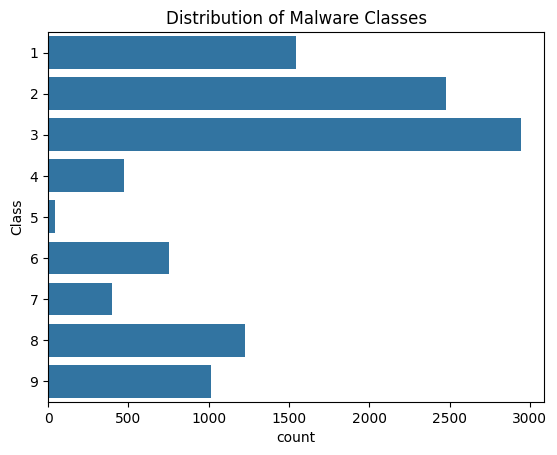

In [11]:
# Class balance
sns.countplot(y='Class', data=df)
plt.title("Distribution of Malware Classes")
plt.show()

In [14]:
df['Class'].value_counts(normalize=True) * 100  # Percentage proportion per class


,proportion
Class,
3,27.070298
2,22.800883
1,14.179242
8,11.299227
9,9.320942
6,6.910195
4,4.370629
7,3.662127
5,0.386456


In [13]:
# Seperating the features and target
y = df['Class']
X = df.drop(columns = 'Class')

In [15]:
# Splitting data into train set and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=2
)

In [16]:
# Feature Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
# Training a baseline Random Forest Classification model before tuning parameters

rf = RandomForestClassifier(random_state=42,
                            n_jobs=-1)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)

print("Baseline Classification Report:\n", classification_report(y_test, y_pred))
print("Baseline Log Loss:", log_loss(y_test, y_proba))


Baseline Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.99      0.98       385
           2       1.00      0.99      1.00       619
           3       1.00      1.00      1.00       736
           4       0.98      1.00      0.99       119
           5       1.00      1.00      1.00        10
           6       0.98      0.97      0.98       188
           7       1.00      1.00      1.00       100
           8       0.99      0.96      0.97       307
           9       0.99      0.99      0.99       253

    accuracy                           0.99      2717
   macro avg       0.99      0.99      0.99      2717
weighted avg       0.99      0.99      0.99      2717

Baseline Log Loss: 0.07426507675869919


In [18]:
# accuracy per class for baseline model
from sklearn.metrics import confusion_matrix

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Accuracy per class = diagonal / row sum
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Display with class labels
for idx, acc in enumerate(class_accuracies):
    print(f"Accuracy for class {idx}: {acc:.4f}")


Accuracy for class 0: 0.9922
Accuracy for class 1: 0.9935
Accuracy for class 2: 0.9986
Accuracy for class 3: 1.0000
Accuracy for class 4: 1.0000
Accuracy for class 5: 0.9734
Accuracy for class 6: 1.0000
Accuracy for class 7: 0.9577
Accuracy for class 8: 0.9921


In [19]:
# lets aim for 100 percent accuracy for all classes
# tuning the random forest model with Grid Search CV

param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', # to deal with class imbalance
                                     random_state=2, n_jobs=-1),
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=3,
    verbose=2
)
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best log loss:", -grid.best_score_)
best_rf = grid.best_estimator_


Fitting 3 folds for each of 400 candidates, totalling 1200 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   2.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   2.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=150; total time=   2.1s
[CV] END max_depth=None, max_f

Tuned Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.99      0.98       385
           2       1.00      0.99      0.99       619
           3       1.00      1.00      1.00       736
           4       0.98      0.99      0.99       119
           5       1.00      1.00      1.00        10
           6       0.98      0.98      0.98       188
           7       1.00      1.00      1.00       100
           8       0.99      0.96      0.98       307
           9       0.99      0.99      0.99       253

    accuracy                           0.99      2717
   macro avg       0.99      0.99      0.99      2717
weighted avg       0.99      0.99      0.99      2717

Tuned Log Loss: 0.0627583920913159


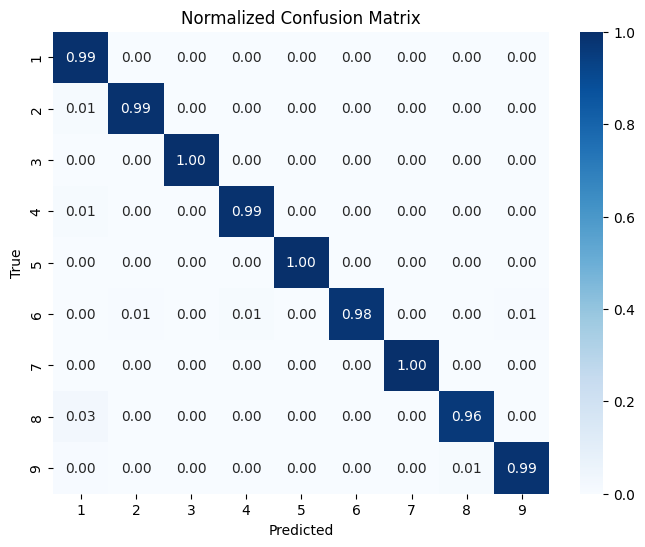

In [20]:
# Evaluation of tuned model

best_params = "'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200"
y_pred_tuned = best_rf.predict(X_test_scaled)
y_proba_tuned = best_rf.predict_proba(X_test_scaled)

print("Tuned Classification Report:\n", classification_report(y_test, y_pred_tuned))
print("Tuned Log Loss:", log_loss(y_test, y_proba_tuned))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned, normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()


In [21]:
# accuracy per class for baseline model
from sklearn.metrics import confusion_matrix

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned)

# Accuracy per class = diagonal / row sum
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Display with class labels
for idx, acc in enumerate(class_accuracies):
    print(f"Accuracy for class {idx}: {acc:.4f}")

Accuracy for class 0: 0.9922
Accuracy for class 1: 0.9919
Accuracy for class 2: 0.9986
Accuracy for class 3: 0.9916
Accuracy for class 4: 1.0000
Accuracy for class 5: 0.9787
Accuracy for class 6: 1.0000
Accuracy for class 7: 0.9642
Accuracy for class 8: 0.9881


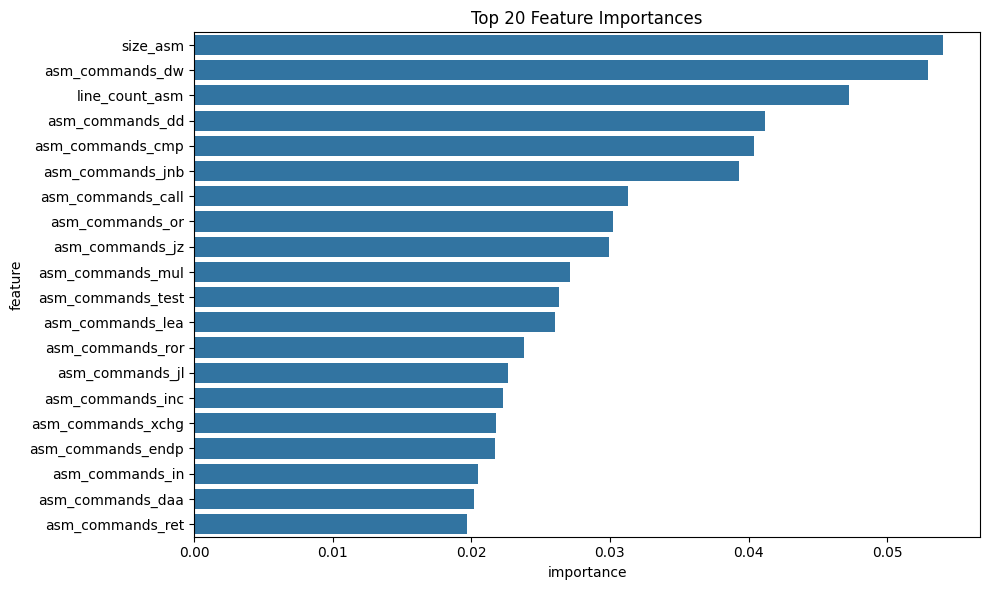

In [22]:
# feature importance analysis

importances = best_rf.feature_importances_
feat_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_df = feat_df.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_df)
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()


In [23]:
# saving the model

import joblib

# Save the model
joblib.dump(best_rf, 'random_forest_model.pkl')


['random_forest_model.pkl']